# Introduction to vector databases on S&P 500 news

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [19]:
%pip install sentence-transformers
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [21]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [22]:
# STEP 1 PREPARE THE DOCUMENTS

df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ". " + df_news['SUMMARY']

# STEP 2 LOAD EMBEDING MODEL

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# STEP 3 DEFINE CUSTOM VECTORSTORE CLASS

from sklearn.metrics.pairwise import cosine_similarity

class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "The number of documents has to be the same as the meta data."
        
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = embedding_model.encode(documents, convert_to_numpy=True)

    def search(self, query, top_k=5, metadata_filter=None):
        filtered_docs = self.documents
        filtered_meta = self.metadata
        filtered_embeds = self.embeddings

        if metadata_filter:
            filtered_indices = [
                i for i, meta in enumerate(self.metadata) if metadata_filter(meta)
            ]
            filtered_docs = [self.documents[i] for i in filtered_indices]
            filtered_meta = [self.metadata[i] for i in filtered_indices]
            filtered_embeds = self.embeddings[filtered_indices]

        if len(filtered_docs) == 0:
            return []

        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True)

        similarities = cosine_similarity(query_embedding, filtered_embeds)[0]

        top_indices = similarities.argsort()[::-1][:top_k]

        results = [(filtered_docs[i], filtered_meta[i], similarities[i])
            for i in top_indices
        ]
        return results


## Create and populate the vector store
 
 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.
 
 After initializing the store, you should be able to perform searches using: 
'store.search("Apple earnings", k=3)'


In [23]:

# CONVERT THE COMBINED EMBEDDED_TEXT COLUM INTO A LIST OF STRINGS

documents = df_news['EMBEDDED_TEXT'].astype(str).tolist()

# CREATE A METADATA LIST OF DDICTIONARIES FOR EACH DOCUMENTS WITH KEYS

metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')

# - Instantiate your CustomVectorStore using:

store = CustomVectorStore(embedding_model, documents, metadata)
 
# After initializing the store, you should be able to perform searches using: 
#'store.search("Apple earnings", k=3)'

results = store.search("APPLE EARNINGS", top_k=3)

for doc, meta, score in results:
    print(f"Document: {doc[:200]}...")
    print(f"Metadata: {meta}")
    print(f"Similarity: {score:.6f}")
    print("-" * 80)

Document: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million. Humana (NYSE:HUM) recently reported first-quarter earnings, showcasing a revenue increase from USD 29,611 millio...
Metadata: {'PUBLICATION_DATE': datetime.date(2025, 5, 28), 'TICKER': 'HUM', 'PROVIDER': 'Simply Wall St.'}
Similarity: 0.578368
--------------------------------------------------------------------------------
Document: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion. ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year,...
Metadata: {'PUBLICATION_DATE': datetime.date(2025, 4, 30), 'TICKER': 'OKE', 'PROVIDER': 'Simply Wall St.'}
Similarity: 0.568715
--------------------------------------------------------------------------------
Document: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain.. Thursday morning, Aptiv reported first-quarter earnings per share

## Using your vector store and analyzing the results

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [24]:
# PERFORM A SEMANTIC SEARCH USING THE QUERY "AI ANNOUNCEMENT" K=50
results = store.search("AI announcement", top_k=50)

for i, (doc, meta, score) in enumerate(results, start=1):
    print(f"RESULT #{i}")
    print(f"TICKER: {meta['TICKER']}")
    print(f"PUBLICATION DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"SIMILARITY SCORE: {score:.4f}")
    print(f"DOCUMENT:{doc}\n")


RESULT #1
TICKER: JKHY
PUBLICATION DATE: 2025-03-17
PROVIDER: Insider Monkey
SIMILARITY SCORE: 0.5574
DOCUMENT:Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

RESULT #2
TICKER: ADBE
PUBLICATION DATE: 2025-05-27
PROVIDER: Investor's Business Daily
SIMILARITY SCORE: 0.5518
DOCUMENT:AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

RESULT #3
TICKER: PLTR
PUBLICATION DATE: 2025-05-31
PROVIDER: Motley Fool
SIMILARITY SCORE: 0.5283
DOCUMENT:Better Artificial Intelligence (AI) Stock: Pal

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?
 
 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [25]:
from collections import Counter

results = store.search("AI announcement", top_k=50)
ticker_counts = Counter([meta['TICKER'] for _, meta, _ in results])

print("Top 50 Companies (frecuency) in query=""AI announcement"" :")
print("\fTICKER\tTIMES")
for ticker, count in ticker_counts.most_common():
    print(f"{ticker} \t  {count}")

Top 50 Companies (frecuency) in query=AI announcement :
TICKER	TIMES
PLTR 	  5
BKR 	  3
AMD 	  3
QCOM 	  2
GOOG 	  2
AMZN 	  2
EXPE 	  2
MSFT 	  2
CTSH 	  2
INTC 	  2
JKHY 	  1
ADBE 	  1
WSM 	  1
CEG 	  1
RSG 	  1
NVDA 	  1
INTU 	  1
GOOGL 	  1
NFLX 	  1
YUM 	  1
SMCI 	  1
ORCL 	  1
META 	  1
ABNB 	  1
PYPL 	  1
CSCO 	  1
NOW 	  1
ROK 	  1
HPQ 	  1
DELL 	  1
CRM 	  1
IT 	  1
FFIV 	  1
AVGO 	  1
KMX 	  1


_I'm not that surprised by the results, the top companies are the ones who are fighting for the AI dominance, there are hardware companies, as well as software companies, the only one that I haven't heard of is 'BKR', wich seems is an energy company_ 

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?
 
 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

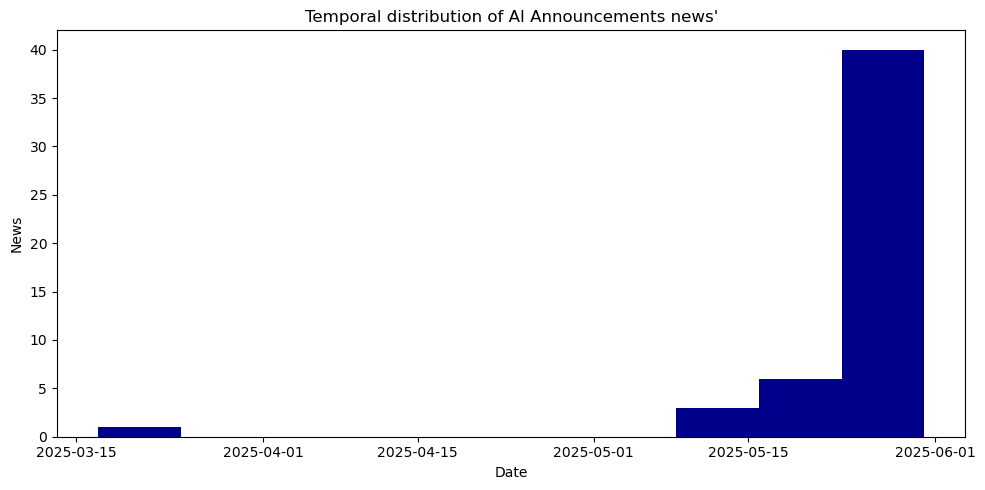

Date Range: 2025-03-17 → 2025-05-31


In [26]:
# EXTRACT THE PUBLICATION DATES OF THE TOP 50 RESULTS

dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]

# PLOT A HISTOGRAM TO VISUALIZE THE TEMPORAL DISTRIBUTION

date_series = pd.to_datetime(dates)

plt.figure(figsize=(10, 5))
plt.hist(date_series, bins=10, color='darkblue')
plt.title("Temporal distribution of AI Announcements news'")
plt.xlabel("Date")
plt.ylabel("News")
plt.tight_layout()
plt.show()
print(f"Date Range: {min(dates)} → {max(dates)}")

_The AI announcements aren´t spread evenly, the are clusteres, specially since the second half of may, the timing of the increase of news related to "AI Announcements" could be, because it and upwarding trend, in the last days the advancements in both hardware and software parts of the AI chain, has made a lot of people trying to catch the trend, mor ecompanies are investing heavy on AI, and the models for some LLM's has been advancing really fast_


## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.
 
 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embeddings
 - Normalize the vectors.
 
 FAISS supports multiple similarity types. For cosine similarity, we must:
 
 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity
 

In [27]:

# USE THE SAME SENTENCE TRANSFORMES MODEL

model = SentenceTransformer('all-MiniLM-L6-v2')
documents = df_news['EMBEDDED_TEXT'].astype(str).tolist()
metadata = df_news[['TICKER', 'PUBLICATION_DATE', 'PROVIDER']].to_dict(orient='records')

# ENCODE TEXT INTO EMBEDDINGS
embeddings = model.encode(documents, convert_to_numpy=True)

# NORMALIZE EMBEDDINGS
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [28]:
embedding_dim = embeddings.shape[1]

# FAISS WITH INDEXFLATIP (INNER PRODUCT) = COSINE SIMILARITY
faiss_index = faiss.IndexFlatIP(embedding_dim)

# AGGREGATE VECTORS TO INDEX
faiss_index.add(embeddings)

### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [29]:

class FaissVectorStore:
    def __init__(self, model, index, documents, metadata):
        self.model = model
        self.index = index
        self.documents = documents
        self.metadata = metadata

    def search(self, query, top_k=5, filters=None): 
        # 1. Codificar y normalizar la consulta
        query_vec = self.model.encode([query], convert_to_numpy=True)
        query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)

        # 2. Buscar en FAISS (obtenemos todos para aplicar filtros después si es necesario)
        similarity_scores, indices = self.index.search(query_vec, k=len(self.documents))

        results = []
        for idx, score in zip(indices[0], similarity_scores[0]):
            doc = self.documents[idx]
            meta = self.metadata[idx]

            # 3. Aplicar filtros si se especifican
            if filters:
                if not all(meta.get(key) == val for key, val in filters.items()):
                    continue

            # 4. Agregar resultado
            results.append((doc, meta, score))

            # 5. Detener si ya se alcanzaron top_k resultados
            if len(results) == top_k:
                break

        return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [30]:
faiss = FaissVectorStore(
    model=model,
    index=faiss_index,
    documents=documents,
    metadata=metadata
)

query = "AI announcement"
k = 50

results = faiss.search(query, top_k=k)

for doc, meta, score in results:
    print("="*100)
    print(f"TICKER: {meta.get('TICKER', 'N/A')}")
    print(f"DATE: {meta.get('PUBLICATION_DATE', 'N/A')}")
    print(f"PROVIDER: {meta.get('PROVIDER', 'N/A')}")
    print(f"SIMILARITY SCORE: {score:.4f}")
    print(f"FULL TEXT:\n{doc}")
    print()

TICKER: JKHY
DATE: 2025-03-17
PROVIDER: Insider Monkey
SIMILARITY SCORE: 0.5574
FULL TEXT:
Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

TICKER: ADBE
DATE: 2025-05-27
PROVIDER: Investor's Business Daily
SIMILARITY SCORE: 0.5518
FULL TEXT:
AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

TICKER: PLTR
DATE: 2025-05-31
PROVIDER: Motley Fool
SIMILARITY SCORE: 0.5283
FULL TEXT:
Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake. Shares of both Palantir and Snowflake h

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [31]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'
]

In [32]:
def compare_retrievals(queries, top_k=5):
    for query in queries:
        print(f"\nQUERY: {query}")
        print("-" * 90)

        custom_results = store.search(query, top_k=top_k)
        faiss_results = faiss.search(query, top_k=top_k)

        print("CustomVectorStore Top 5 Results:")
        for i, (doc, meta, score) in enumerate(custom_results, start=1):
            print(f"{i}. [{meta['TICKER']}] {doc[:100]}...\t(Score: {score:.6f})")

        print("\nFAISS Vector Store Top 5 Results:")
        for i, (doc, meta, score) in enumerate(faiss_results, start=1):
            print(f"{i}. [{meta['TICKER']}] {doc[:100]}...\t(Score: {score:.6f})")

        print("=" * 90)


compare_retrievals(test_queries, top_k=5)


QUERY: Stock price drop
------------------------------------------------------------------------------------------
CustomVectorStore Top 5 Results:
1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar...	(Score: 0.542683)
2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachea...	(Score: 0.540825)
3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, W...	(Score: 0.539527)
4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 ...	(Score: 0.538577)
5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won't beat Nvidia in the AI processor marke...	(Score: 0.537130)

FAISS Vector Store Top 5 Results:
1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar...	(Score: 0.542683)
2. [NOW] ServiceNow (NOW) Sto

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

_The results at the begining, appear strange to me, because they have the same similarity Score, but in a depth analyisis this in somewhat  expected, this is because we are employeing the same model to embedding "all-MiniLM-L6-v2", also we are using cosine similarity in both and in top of that we are normalizing the embeddings, so, it creates similar value vectors._ 

_Aditionally since we query the top 5 results, it is naturally that the tend to appear in the rsame order regarding of the retrieval strategy, also, the queries have strong keywords wich emphatizes the similarities._

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [33]:
# PREPARE MODELS AND CREATE THE 2 VECTOR STORES

from sentence_transformers import SentenceTransformer

# PREPARE BOTH MODELS
model_mini = SentenceTransformer('all-MiniLM-L6-v2')
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

# DOCUMENTS AND METADATA
documents = df_news['EMBEDDED_TEXT'].astype(str).tolist()
metadata = df_news[['TICKER', 'PUBLICATION_DATE', 'PROVIDER']].to_dict(orient='records')

# INSTANCE
store_mini = CustomVectorStore(model_mini, documents, metadata)
store_mpnet = CustomVectorStore(model_mpnet, documents, metadata)

# DEF

def compare_models(queries, top_k=5):
    for query in queries:
        print(f"\nQUERY: {query}\f")

        mini_results = store_mini.search(query, top_k=top_k)
        mpnet_results = store_mpnet.search(query, top_k=top_k)

        print("all-MiniLM-L6-v2 Top 5 Results:")
        for i, (doc, meta, score) in enumerate(mini_results, start=1):
            print(f"{i}. [{meta['TICKER']}] {doc[:60]}... (Score: {score:.4f})")

        print("\nall-mpnet-base-v2 Top 5 Results:")
        for i, (doc, meta, score) in enumerate(mpnet_results, start=1):
            print(f"{i}. [{meta['TICKER']}] {doc[:60]}... (Score: {score:.4f})")

        print("=" * 90)

# TEST

test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'
]

compare_models(test_queries, top_k=5)


QUERY: Stock price drop
all-MiniLM-L6-v2 Top 5 Results:
1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mo... (Score: 0.5427)
2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important... (Score: 0.5408)
3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories,... (Score: 0.5395)
4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Fact... (Score: 0.5386)
5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won... (Score: 0.5371)

all-mpnet-base-v2 Top 5 Results:
1. [ALGN] Fortune Brands, Whirlpool, Align Technology, Tandem Diabetes... (Score: 0.6400)
2. [DHR] Danaher, Illumina, Globalstar, and Insperity Shares Plummet,... (Score: 0.6219)
3. [HPQ] Watch These HP Price Levels as Stock Tumbles After Company C... (Score: 0.6092)
4. [CRL] Guardant Health, Evolent Health, Charles River Laboratories,... (Score: 0.6024)
5. [CBRE] Sonos, CBRE, RE/MAX, WillScot Mobile Mini, and Builders Firs... (Score: 0.5940)

QUERY: Layoffs

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

_I'm going to start by analyzing cualitative both models, because they are 2 diferent models for diferent purpouses, 'all_MiniLM-L6-v2' its a smaller model, wich make it great for reduced computational cost, for its speed and low latency, whereas 'all-mpnet-base-v2' its a larger model, wich in theory will produce embedding with richer semantics, but this come at a computational cost andslower speeds and greater latency_
 
_Example_

_QUERY: Stock price drop_

_all-mpnet-base-v2 Top Results:_

_[DHR] Danaher, Illumina, Globalstar, and Insperity Shares Plummet,... (Score: 0.6219)_

_The word "Plummet" describes a strong fall in the value of a stock, this new didnt appear in  the retrievals made with 'all-MiniLM-L6-v2', this is an important new that should appear in the top 5 news for the query, so based in the theorical and practical information, the best model for retrieving relevant documents for the queries its the more complex model 'all-mpnet-base-v2'._

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

_When a model made and embedding of a sentence, it has a lot of variations, based on the complexity opf the model, so, for the same sentence or text diferentmodels will have diferent values in its vector values,  in the custom vector store we use cosine similarity wich its a function of sklearn wich automatically normalizes the vector internally, however this didn't occur when we employ FAIIS, since we have using IndexFlatIP wich searchs by dot product, this will make FAISS rank documents based on a value weighted product, not by semantic similarity, wich is why we have to enforce the normalization of the FAISS vectors, in summary, the normalization ensures the semantic similarity._



### **Q6.**  What would happen if vectors were not normalized before indexing?


_If vectors were'nt normalized before inddexing, FAISS will rank the results by vector magnitude, not by semantic similarity, this means the documents with larger vectors will dominate over the shorter ones, this will affect the semantic precision, so it is important to normalize the vector, in order to every one has the same opportunity of be selected by similarity._



## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?



_Starting from a technical perspective FAISS its more robust, since it has been designed to deal with huge vector databases, it is very optimized and fast, sice its backend is programmed in C++, also it is GPU soported, by contrast the Custom Vector Store from sklearn its slower since it's backend relays on Python, Faiss also can made fast aproximations or exact searchs, whereas Custom Vector Store make only exact searched, wich tend to be slower, for a production-scale seach system FAISS its better suited for the job, wherea Custom Vector Store is more for educational or prototyping purpouses._



### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

_The implementation that will scale better its a FAISS one, it's better suited for a production environment, since it could scale horizontally, it's backend its designed in C++ wich it's way more efficient than any implementation made with Python (less memory, and less computational cost), It offers more robust ways to compute the similarities, wich by the way they could be aproximations (for a case of large databases and fast quering times), in addition, they could run on GPU, wich accelerate the calculations required to form the index_
 